In [105]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import sys
import shapely
import Helper_Methods as hm
from scipy.spatial import cKDTree
import numpy as np
import rasterstats
import rasterio
from rasterio.plot import show
import georaster
from PIL import Image
from PIL.TiffTags import TAGS

In [126]:
%%time
route_paths = "./Data/Routes/Comprehensive_Routes/KCM_Routes.shp"
routes = gpd.read_file(route_paths).to_crs(epsg = 4326)

CPU times: user 426 ms, sys: 1.99 ms, total: 428 ms
Wall time: 426 ms


In [127]:
%%time
elevations_path = "./Data/Lidar/LIDAR.shp"
elevations_raw = gpd.read_file(elevations_path)
elevations = elevations_raw.copy()

CPU times: user 1min 1s, sys: 550 ms, total: 1min 1s
Wall time: 1min


In [128]:
route = 22

In [129]:
import georaster

In [130]:
def organize_linestring(string):
    cat_string = string[12:-1]
    coord_list = cat_string.split(', ')
    coord_ser = pd.Series(coord_list).apply(lambda x: shapely.Point(x.split(' ')[0], x.split(' ')[1]))
    coord_ser = gpd.GeoSeries(coord_ser)
    return coord_ser

In [131]:
dense_geo = pd.Series(list((routes[routes['ROUTE_NUM'] == route]['geometry'].reset_index(drop=True))[0].geoms))
geometry = gpd.GeoSeries()
for linestring in dense_geo:
    geometry = pd.concat([geometry, organize_linestring(str(linestring))])

    

rasters_data_dir = "./Data/Raster_Data/KC3/"
rasterfiles_raw = pd.Series(os.listdir(rasters_data_dir))
rasterfiles = rasterfiles_raw[rasterfiles_raw.apply(lambda x: ('tif' in (x.split("."))[-1]))].reset_index(drop='true')
rasterfiles = rasterfiles.apply(lambda x: "{}{}".format(rasters_data_dir, x))


./Data/Raster_Data/KC3/king_county_west_2021_dtm_89_hs.tif
./Data/Raster_Data/KC3/king_county_west_2021_dtm_92_hs.tif
./Data/Raster_Data/KC3/king_county_west_2021_dtm_70_hs.tif
./Data/Raster_Data/KC3/king_county_west_2021_dtm_65_hs.tif
./Data/Raster_Data/KC3/king_county_west_2021_dtm_87_hs.tif


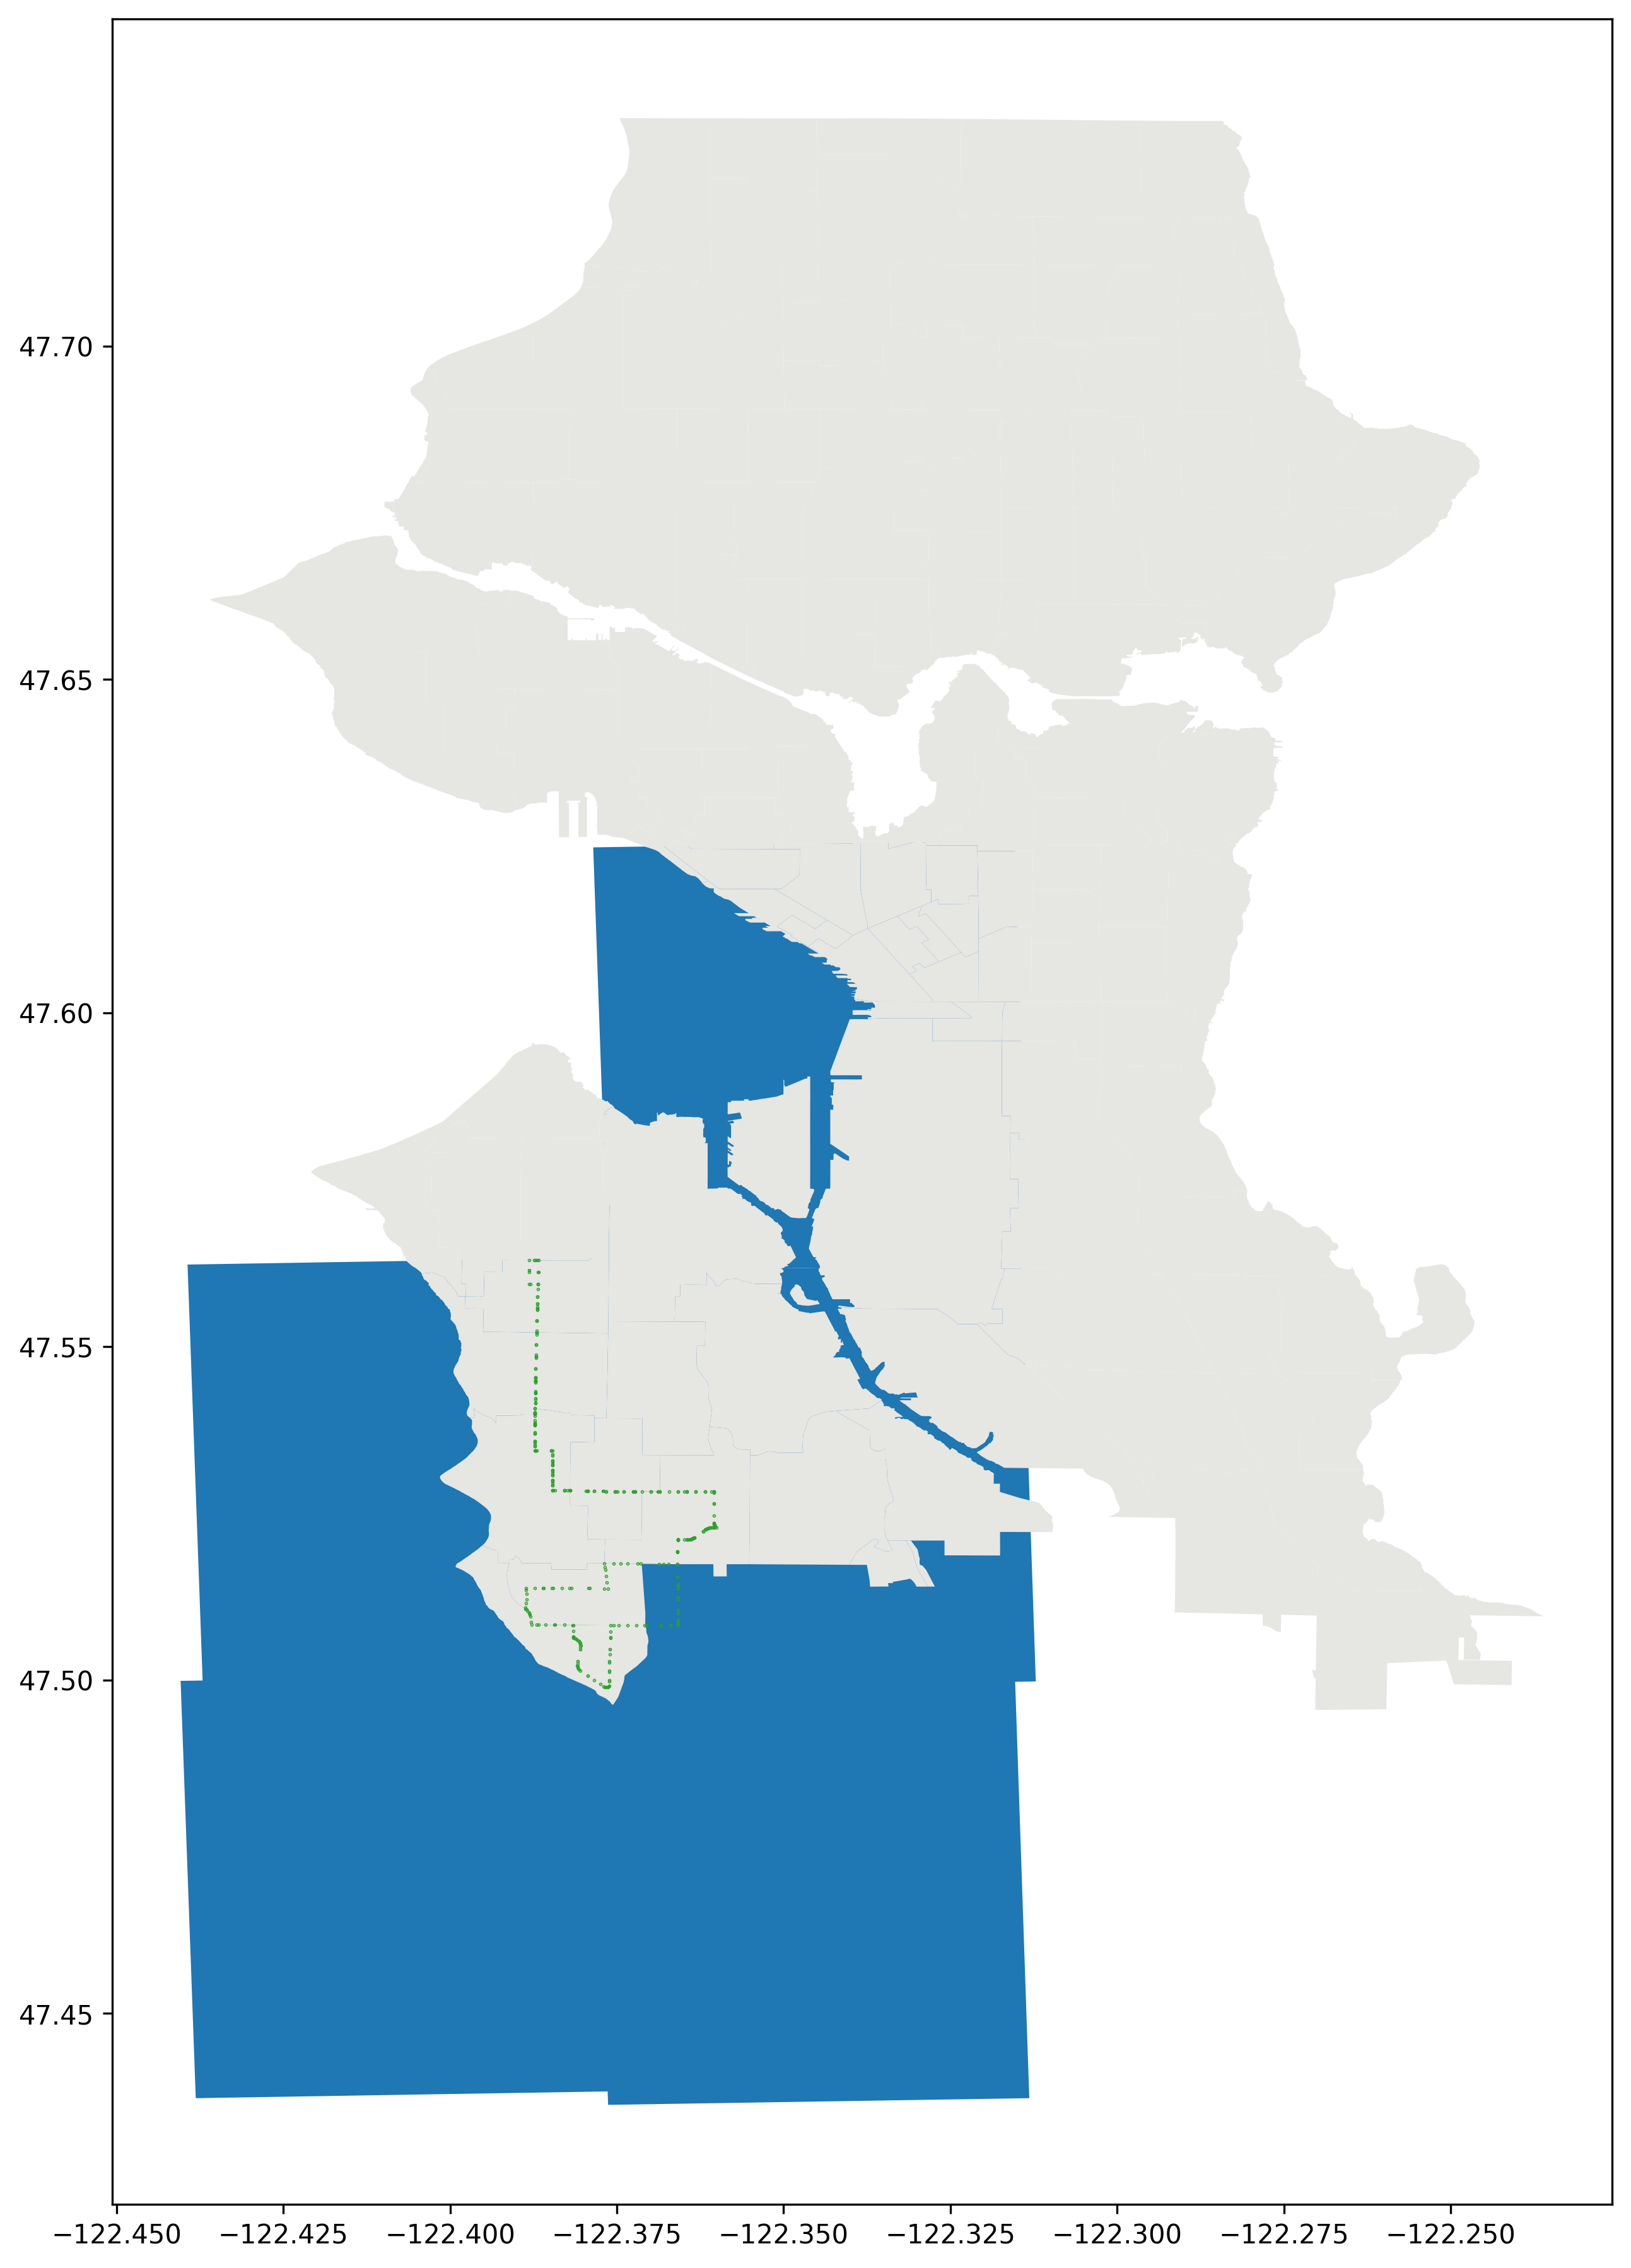

In [154]:
import warnings
warnings.filterwarnings("ignore")
metadata_list = []
bounds = {'path':[], 'geometry':[]}
for raster_subset in rasterfiles[:]:
    
    with Image.open(raster_subset) as img:
        meta_dict = {TAGS[key] : img.tag[key] for key in img.tag_v2}
        pixel_scale = meta_dict['ModelPixelScaleTag'][:2]
        # upper left, lower left, upper right, lower right
        width_coords = meta_dict['ImageWidth'][0]*pixel_scale[0]
        height_coords = meta_dict['ImageLength'][0]*-pixel_scale[1]
        corners = [[0,0],
                   [width_coords, 0],
                   [0, height_coords],
                   [width_coords, height_coords]]
        for coord in corners:
            coord[0]=coord[0]+meta_dict['ModelTiepointTag'][3]
            coord[1]=coord[1]+meta_dict['ModelTiepointTag'][4]
        bounds['path'].append(raster_subset)
        bounds['geometry'].append(hm.get_bounding_box(shapely.LineString(corners)))
#print(bounds)
bound_gdf = gpd.GeoDataFrame(bounds, crs="NAD83(HARN) / Washington South (ftUS)")
bound_gdf = bound_gdf.to_crs(epsg = 4326)

dense_geo = pd.Series(list((routes[routes['ROUTE_NUM'] == route]['geometry'].reset_index(drop=True))[0].geoms))
geometry = gpd.GeoSeries()
for linestring in dense_geo:
    geometry = pd.concat([geometry, organize_linestring(str(linestring))])

route_bounds = hm.get_bounding_box(shapely.LineString(geometry))

bound_gdf['contains_route'] = bound_gdf['geometry'].apply(lambda x: shapely.overlaps(x,route_bounds))
f_gdf = bound_gdf[bound_gdf['contains_route']==True]
fig, ax = plt.subplots(1, figsize = (15, 15), dpi=300)
f_gdf.plot(ax=ax, zorder=0)

seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

seattle.plot(color="#E6E6E3", ax=ax, zorder = 10)
geometry.plot(color="tab:green", ax=ax, zorder = 30, markersize=.1)
for item in f_gdf['path']: print(item)

In [100]:
str(route_bounds)

'POLYGON ((-122.38874290259594 47.49892287977223, -122.38874290259594 47.56294684155153, -122.36009950624877 47.56294684155153, -122.36009950624877 47.49892287977223, -122.38874290259594 47.49892287977223))'

In [116]:
#filtered_gdf = bound_gdf[bound_gdf['contains_route']==True]


'''
        asciitags = str(meta_dict['GeoAsciiParamsTag'])[2:-4].split("|")
        data_dict = {}
        data_dict['Upper_Left_CD'] = meta_dict['ModelTiepointTag'][3:5]
        for combined_tag in asciitags:

            try:
                split = combined_tag.split(" = ")
                key = split[0]
                value = split[1]
                data_dict[key] = value
            except:
                e = 1
        #print(meta_dict.keys())
        for key in list(meta_dict.keys()):
            if (key != "TileOffsets") and (key != "TileByteCounts"):
                print("{}  |>    {}".format(key, meta_dict[str(key)]))
        metadata_list.append(data_dict)

    #dem = rasterio.open(raster_subset)
    #dem_array = dem.read(1).astype('float64')
    #fig, ax = plt.subplots(1, figsize=(12, 12))
    #show(dem_array, cmap='Greys_r', ax=ax)
'''
#df = pd.DataFrame(metadata_list)
#df


'\n        asciitags = str(meta_dict[\'GeoAsciiParamsTag\'])[2:-4].split("|")\n        data_dict = {}\n        data_dict[\'Upper_Left_CD\'] = meta_dict[\'ModelTiepointTag\'][3:5]\n        for combined_tag in asciitags:\n\n            try:\n                split = combined_tag.split(" = ")\n                key = split[0]\n                value = split[1]\n                data_dict[key] = value\n            except:\n                e = 1\n        #print(meta_dict.keys())\n        for key in list(meta_dict.keys()):\n            if (key != "TileOffsets") and (key != "TileByteCounts"):\n                print("{}  |>    {}".format(key, meta_dict[str(key)]))\n        metadata_list.append(data_dict)\n\n    #dem = rasterio.open(raster_subset)\n    #dem_array = dem.read(1).astype(\'float64\')\n    #fig, ax = plt.subplots(1, figsize=(12, 12))\n    #show(dem_array, cmap=\'Greys_r\', ax=ax)\n'

In [24]:
import rasterio
from rasterio.plot import show

In [9]:
rasterio.open()

Series([], dtype: object)

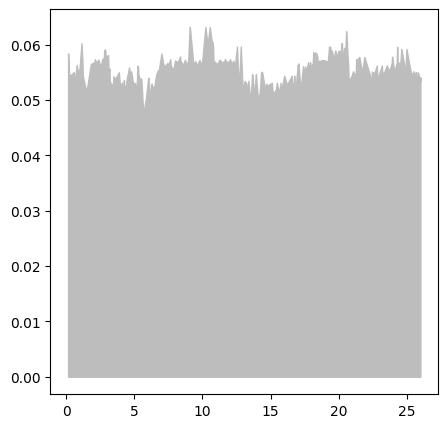

In [16]:
y = pd.Series(elevation, name='Z')*0.0003048
fig, ax = plt.subplots(1, figsize = (5, 5), dpi = 100)
ax.fill_between(x, y, color = '#BDBDBD')

In [ ]:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

fig, ax = plt.subplots(1, figsize = (5,10), dpi=300)

seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)
geometry.plot(color="lime", ax=ax, markersize=.1, zorder=15)


In [70]:
filtered_elevations

,OBJECTID,GPS_Time,Northing,Easting,Height,YYYYMMDD,geometry
4914,4915,595567,249915.817,1282735.829,1477.828,20160326,POINT Z (-122.28532 47.67589 1477.82800)
4915,4916,595568,249848.274,1282507.102,1484.022,20160326,POINT Z (-122.28624 47.67569 1484.02200)
4916,4917,595569,249781.967,1282279.136,1494.327,20160326,POINT Z (-122.28716 47.67550 1494.32700)
4917,4918,595570,249716.913,1282051.758,1503.057,20160326,POINT Z (-122.28808 47.67531 1503.05700)
4918,4919,595571,249653.591,1281824.830,1511.886,20160326,POINT Z (-122.28900 47.67512 1511.88600)
...,...,...,...,...,...,...,...
347278,347279,421550,242366.190,1281663.530,5126.010,20160225,POINT Z (-122.28909 47.65514 5126.01000)
347279,347280,421551,242121.360,1281661.310,5126.030,20160225,POINT Z (-122.28908 47.65447 5126.03000)
347280,347281,421552,241877.290,1281658.770,5127.660,20160225,POINT Z (-122.28907 47.65380 5127.66000)
347281,347282,421553,241633.820,1281655.690,5128.060,20160225,POINT Z (-122.28907 47.65313 5128.06000)


In [ ]:
route_data_dir = "./Data/Routes/Individual_Routes/"
routefiles_raw = pd.Series(os.listdir(route_data_dir))
routefiles = routefiles_raw[routefiles_raw.apply(lambda x: ('shp' in (x.split("."))[-1]))].reset_index(drop='true')
routefiles = routefiles.apply(lambda x: "{}{}".format(route_data_dir, x))

In [ ]:
contours_data_dir = "./Data/Contours/"
contourfiles_raw = pd.Series(os.listdir(contours_data_dir))
contourfiles = contourfiles_raw[contourfiles_raw.apply(lambda x: ('shp' in (x.split("."))[-1]))].reset_index(drop='true')
contourfiles = contourfiles.apply(lambda x: "{}{}".format(contours_data_dir, x))

In [20]:
contour = gpd.read_file(contourfiles[1]).to_crs(epsg = 4326)

In [ ]:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

fig, ax = plt.subplots(1, figsize = (5,10), dpi=3000)

seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)

for contour_subset in contourfiles:
    print(contour_subset)
    contour = gpd.read_file(contour_subset).to_crs(epsg = 4326)
    contour.plot(color="tab:orange", ax=ax, markersize=.1)
    del(contour)
    
plt.show()

./Data/Contours/t20r03_contour005.shp
./Data/Contours/t20r11_contour005.shp
./Data/Contours/t22r11_contour005.shp
./Data/Contours/t18r11_contour005.shp
./Data/Contours/t22r09_contour005.shp


In [16]:
elevations = elevations.to_crs(epsg = 4326)

<Axes: >

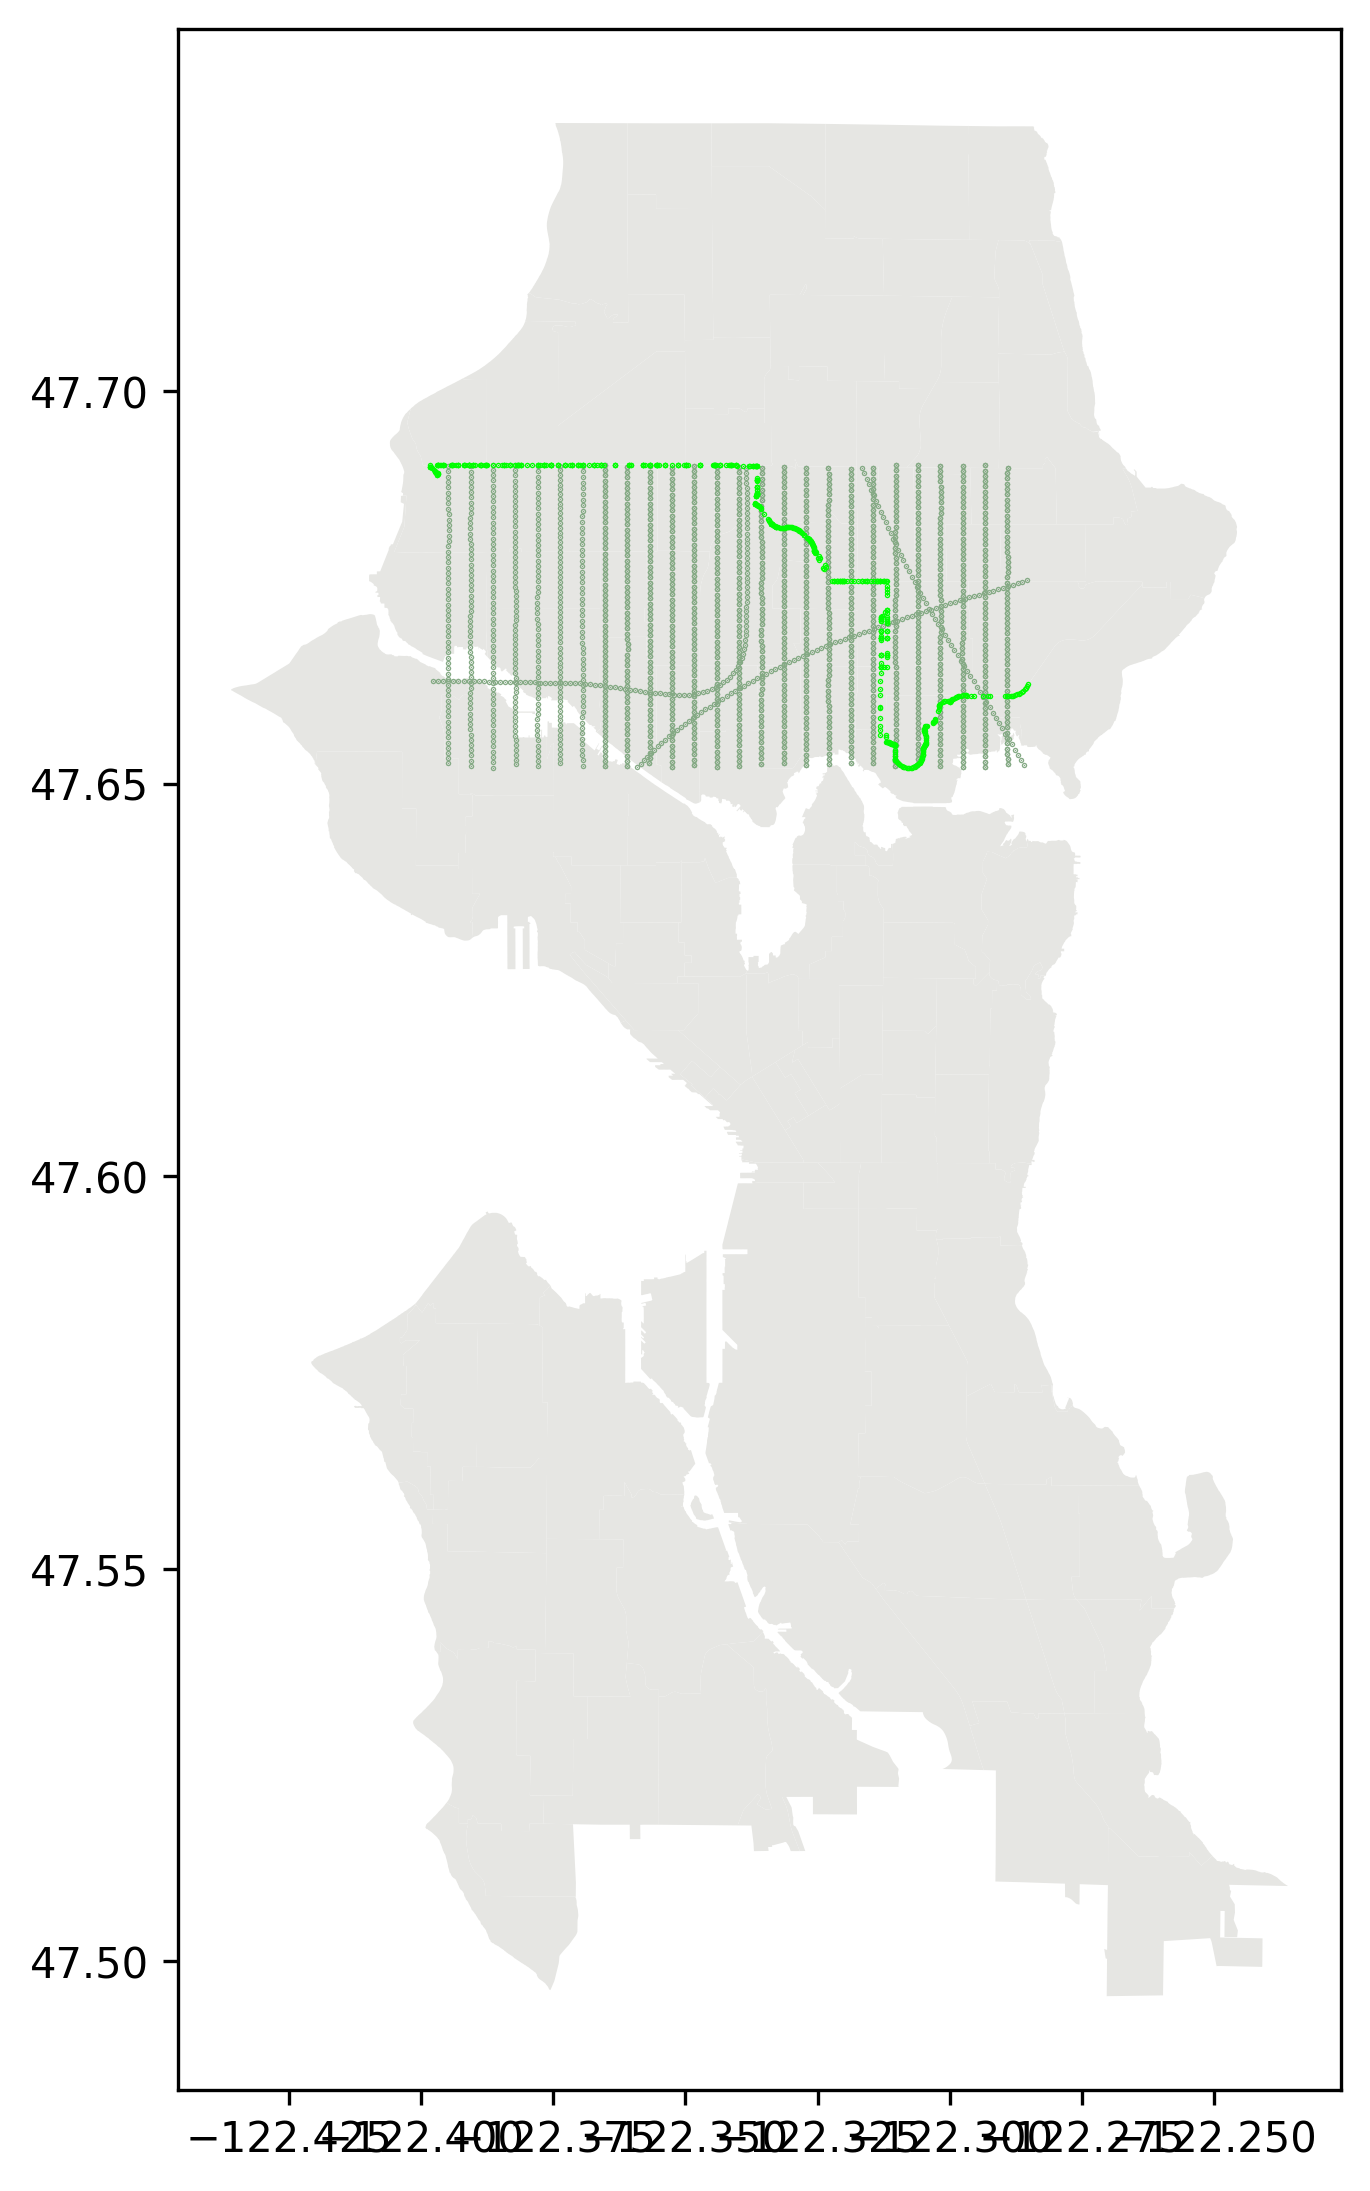

In [18]:
dense_geo = pd.Series(list((routes[routes['ROUTE_NUM'] == route]['geometry'].reset_index(drop=True))[0].geoms))
geometry = gpd.GeoSeries()
for linestring in dense_geo:
    geometry = pd.concat([geometry, organize_linestring(str(linestring))])


route_bounds = hm.get_bounding_box(shapely.LineString(geometry))
filtered_elevations = elevations[(elevations['geometry']).apply(lambda x: shapely.contains(route_bounds, x)) == True]

seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

fig, ax = plt.subplots(1, figsize = (5,10), dpi=300)

seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)
geometry.plot(color="lime", ax=ax, markersize=.1, zorder=15)
filtered_elevations.plot(color="#85AA85", ax=ax, zorder=.5, markersize=.1)


In [76]:
from PyQt5.QtGui import *
from PyQt5.QtCore import *
from qgis.core import *
from qgis.utils import iface

project = QgsProject.instance() 
mFile=QFileInfo("C://Users//fran//Desktop//test.qgs")

project.write(mFile)

project.clear()

project.read(mFile)

ModuleNotFoundError: No module named 'qgis'

In [74]:
!pip3 install pyqt5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 35.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 MB 21.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 kB 15.8 MB/s eta 0:00:00


In [75]:
!pip3 install qgis

ERROR: Could not find a version that satisfies the requirement qgis (from versions: none)
ERROR: No matching distribution found for qgis
